In [1]:
import os
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings
from jsindy.optim.optimizers import AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ,SSR,MIOSR
from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp
import time
import matplotlib.pyplot as plt

# Cranking up the collocation weight even higher is not necessarily a good idea

## But we can do it now!

In [16]:
exp_data = LorenzExp
initial_state = jnp.array([ 0.37719066, -0.39631459, 16.92126795])
dt = 0.2
noise_var = 4.
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 505
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=29,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)


trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 1000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100,
)
data_weight =  1.
colloc_weight = 2000. * n_colloc * 3
sparsifier = pySindySparsifier(
    STLSQ(threshold = 0.25,alpha = 0.1)
    )

# sparsifier = pySindySparsifier(
#     MIOSR(target_sparsity = 7,alpha = 0.1)
#     )

In [17]:
optimizer = AlternatingActiveSetLMSolver(
        beta_reg=0.001,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=expdata.feature_names
)

# nodes,weights = legendre_nodes_weights(500,t0,t1)

model.fit(
    expdata.t_train,
    expdata.x_train,
    t_colloc = expdata.t_colloc,
    w_colloc = expdata.w_colloc
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics['model_params'] = model.params

model.print()

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(1.0000003e-08, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 3030000.0}
Warm Start


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 9.514e+08, gradnorm = 3.013e+09, alpha = 4.167, improvement_ratio = 0.8031
Iteration 1, loss = 1.939e+08, gradnorm = 1.322e+10, alpha = 4.167, improvement_ratio = 0.7962
Line Search Failed!
Final Iteration Results
Iteration 2, loss = 2.234e+09, gradnorm = 1.322e+10, alpha = 1.663e+04, improvement_ratio = -10.52
Model after smooth warm start
(x)' = -2.427 1 + 2.705 x + 7.643 y + 1.550 z + 1.063 x^2 + -1.301 x y + -0.279 x z + 0.537 y^2 + -0.057 y z + -0.146 z^2
(y)' = -7.848 1 + 6.097 x + 10.012 y + 0.699 z + 0.254 x^2 + 0.307 x y + -0.551 x z + -0.067 y^2 + -0.136 y z + -0.086 z^2
(z)' = 72.638 1 + 9.565 x + 2.515 y + -10.460 z + -1.943 x^2 + 2.946 x y + -0.703 x z + 0.160 y^2 + 0.128 y z + 0.181 z^2
Alternating Activeset Sparsifier
10 active coeffs changed
2 active coeffs changed
Line search Failed
5 active coeffs changed
Line search Failed
1 active coeffs changed
Line search Failed
1 active coeffs changed
Line search Failed
1 active coeffs changed
Line search Fail

In [18]:
optimizer = AnnealedAlternatingActiveSetLMSolver(
        beta_reg=0.001,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=expdata.feature_names
)

# nodes,weights = legendre_nodes_weights(500,t0,t1)

model.fit(
    expdata.t_train,
    expdata.x_train,
    t_colloc = expdata.t_colloc,
    w_colloc = expdata.w_colloc
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics['model_params'] = model.params


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(1.0000008e-08, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 3030000.0}
Solving for data_weight = 1.0, colloc_weight = 24240.0 beta_reg = 0.008


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 7.567e+06, gradnorm = 2.411e+07, alpha = 4.167, improvement_ratio = 0.8042
Iteration 1, loss = 1.535e+06, gradnorm = 1.062e+08, alpha = 4.167, improvement_ratio = 0.7971
Iteration 2, loss = 1.228e+06, gradnorm = 4.907e+07, alpha = 2.737e+03, improvement_ratio = 0.2008
Iteration 3, loss = 2.949e+05, gradnorm = 1.301e+08, alpha = 100.0, improvement_ratio = 0.7603
Iteration 4, loss = 2.936e+04, gradnorm = 4.667e+07, alpha = 83.33, improvement_ratio = 0.9022
Iteration 5, loss = 1.677e+04, gradnorm = 2.785e+07, alpha = 125.0, improvement_ratio = 0.4369
Iteration 100, loss = 242.5, gradnorm = 3.303e+04, alpha = 9.346, improvement_ratio = 0.7321
Iteration 200, loss = 192.7, gradnorm = 3.034e+03, alpha = 0.02734, improvement_ratio = 0.7968
Line Search Failed!
Final Iteration Results
Iteration 226, loss = 192.6, gradnorm = 0.01164, alpha = 148.4, improvement_ratio = -3.697e+04
Solving for data_weight = 1.0, colloc_weight = 121200.0 beta_reg = 0.004


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 198.4, gradnorm = 649.8, alpha = 102.5, improvement_ratio = 0.134
Iteration 1, loss = 197.4, gradnorm = 1.195e+05, alpha = 83.33, improvement_ratio = 0.9213
Iteration 2, loss = 197.1, gradnorm = 3.417e+04, alpha = 69.44, improvement_ratio = 0.8673
Iteration 3, loss = 196.7, gradnorm = 2.451e+04, alpha = 57.87, improvement_ratio = 0.8928
Iteration 4, loss = 196.5, gradnorm = 1.757e+04, alpha = 48.23, improvement_ratio = 0.9044
Iteration 5, loss = 196.3, gradnorm = 1.431e+04, alpha = 40.19, improvement_ratio = 0.9035
Line Search Failed!
Final Iteration Results
Iteration 92, loss = 194.2, gradnorm = 0.2064, alpha = 2.434e+03, improvement_ratio = -6.823e+04
Solving for data_weight = 1.0, colloc_weight = 606000.0 beta_reg = 0.002


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 196.5, gradnorm = 652.5, alpha = 102.5, improvement_ratio = 0.1207
Iteration 1, loss = 196.0, gradnorm = 2.831e+05, alpha = 83.33, improvement_ratio = 0.9397
Iteration 2, loss = 195.8, gradnorm = 3.359e+04, alpha = 69.44, improvement_ratio = 0.886
Iteration 3, loss = 195.7, gradnorm = 5.102e+04, alpha = 57.87, improvement_ratio = 0.9078
Iteration 4, loss = 195.5, gradnorm = 4.893e+04, alpha = 48.23, improvement_ratio = 0.9234
Iteration 5, loss = 195.4, gradnorm = 4.35e+04, alpha = 40.19, improvement_ratio = 0.9309
Line Search Failed!
Final Iteration Results
Iteration 100, loss = 194.7, gradnorm = 1.2, alpha = 9.463e+03, improvement_ratio = -1.032e+04
Solving for data_weight = 1.0, colloc_weight = 3030000.0 beta_reg = 0.001


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 195.3, gradnorm = 653.0, alpha = 192.2, improvement_ratio = 0.3654
Iteration 1, loss = 195.1, gradnorm = 4.392e+05, alpha = 100.0, improvement_ratio = 0.6957
Iteration 2, loss = 195.0, gradnorm = 2.482e+05, alpha = 83.33, improvement_ratio = 0.8851
Iteration 3, loss = 194.9, gradnorm = 1.947e+05, alpha = 69.44, improvement_ratio = 0.9066
Iteration 4, loss = 194.9, gradnorm = 1.063e+05, alpha = 57.87, improvement_ratio = 0.9398
Iteration 5, loss = 194.9, gradnorm = 4.415e+04, alpha = 48.23, improvement_ratio = 0.9482
Line Search Failed!
Final Iteration Results
Iteration 96, loss = 194.9, gradnorm = 3.568, alpha = 1.024e+04, improvement_ratio = -3.251e+03
Model after smooth warm start
(x)' = 21.426 1 + 2.156 x + 2.323 y + -3.048 z + -1.437 x^2 + 2.170 x y + -0.461 x z + -0.774 y^2 + 0.322 y z + 0.101 z^2
(y)' = -28.105 1 + 23.513 x + 4.772 y + 5.061 z + 2.772 x^2 + -3.028 x y + -0.767 x z + 0.790 y^2 + -0.326 y z + -0.204 z^2
(z)' = 0.597 1 + -3.192 x + 0.916 y + -1.9

In [19]:
model.print()

(x)' = -1.611 1 + -9.711 x + 10.099 y
(y)' = 0.850 1 + 27.327 x + -1.078 y + -0.961 x z
(z)' = -2.687 z + 1.046 x y


In [20]:
model.print(expdata.true_coeff.T)

(x)' = -10.000 x + 10.000 y
(y)' = 28.000 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y


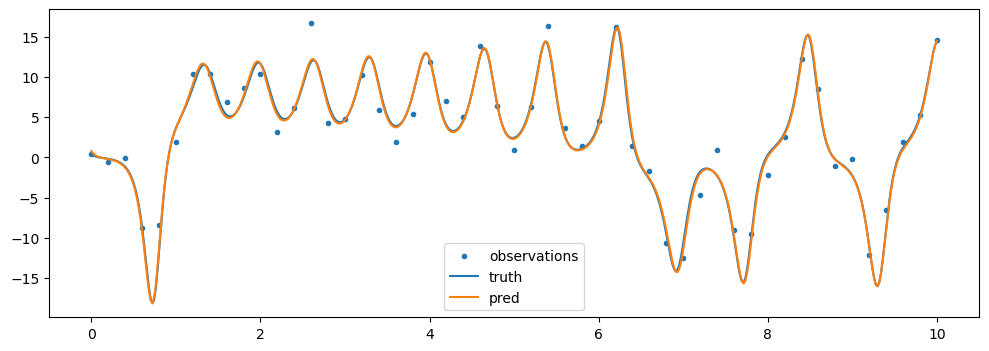

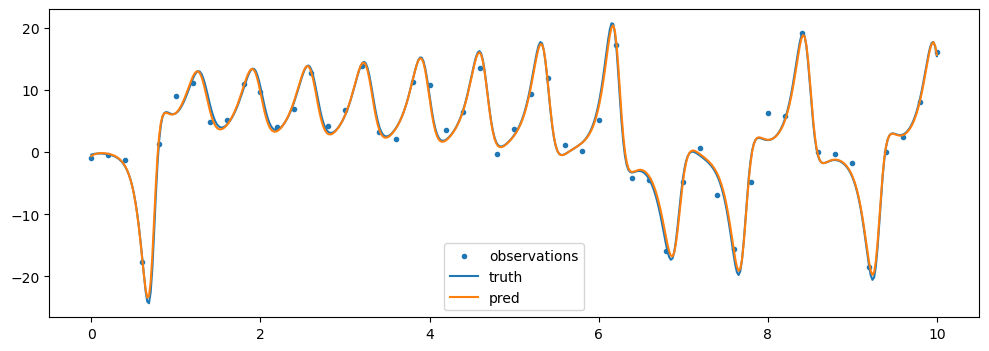

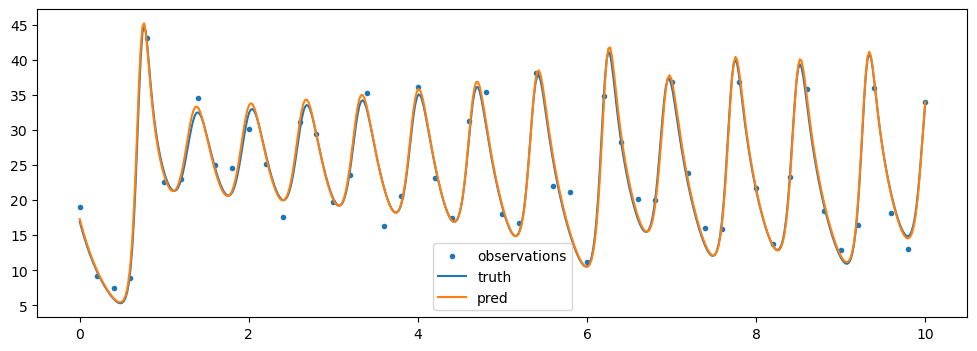

In [21]:
t_grid = jnp.linspace(0,10,500)
state_preds = model.predict_state(t_grid)
true_states = jax.vmap(expdata.system_sol.evaluate)(t_grid)
for dim in range(3):
    plt.figure(figsize=(12,4))
    plt.scatter(expdata.t_train,expdata.x_train[:,dim],label = 'observations',s = 9)
    plt.plot(t_grid,true_states[:,dim],label = 'truth')
    plt.plot(t_grid,state_preds[:,dim],label = 'pred')
    plt.legend()
    plt.show()


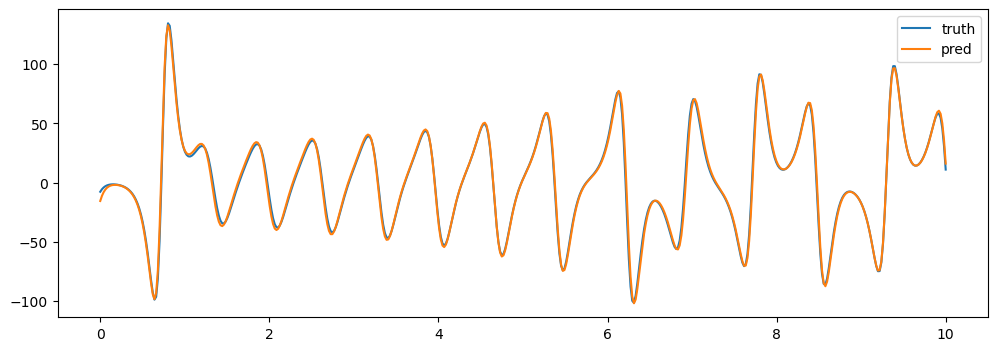

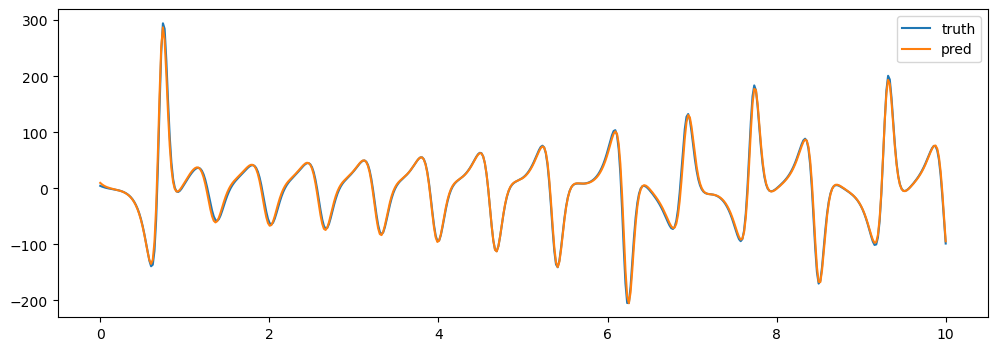

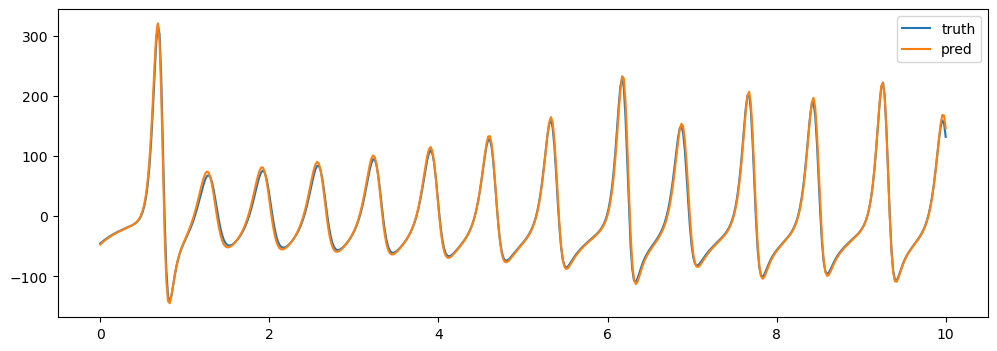

In [22]:
t_grid = jnp.linspace(0,10,500)
dx_preds = model.traj_model.derivative(t_grid,model.z,1)

true_states = jax.vmap(expdata.system_sol.evaluate)(t_grid)
true_dx = model.predict(true_states,expdata.true_coeff.T)
for dim in range(3):
    plt.figure(figsize=(12,4))
    plt.plot(t_grid,true_dx[:,dim],label = 'truth')
    plt.plot(t_grid,dx_preds[:,dim],label = 'pred')
    plt.legend()
    plt.show()


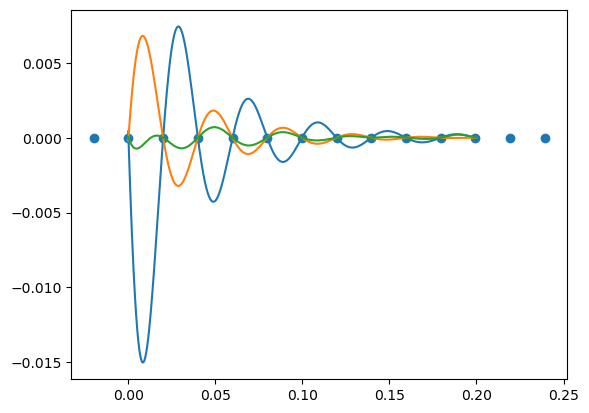

In [23]:
z = model.z
theta = model.theta
lower_t = 0.
end_t = 0.2
t_fine = jnp.linspace(lower_t,end_t,2000)
X_fine = model.predict_state(t_fine,z)
Xdot_fine = model.traj_model.derivative(t_fine,z)
colloc_res_fine = model.predict(X_fine,theta) - Xdot_fine
plt.plot(t_fine,colloc_res_fine[:,0])
plt.plot(t_fine,colloc_res_fine[:,1])
plt.plot(t_fine,colloc_res_fine[:,2])

colloc_plot = model.t_colloc[(model.t_colloc<=end_t+0.05)&(model.t_colloc>=lower_t - 0.05)]
plt.scatter(colloc_plot,0*colloc_plot)

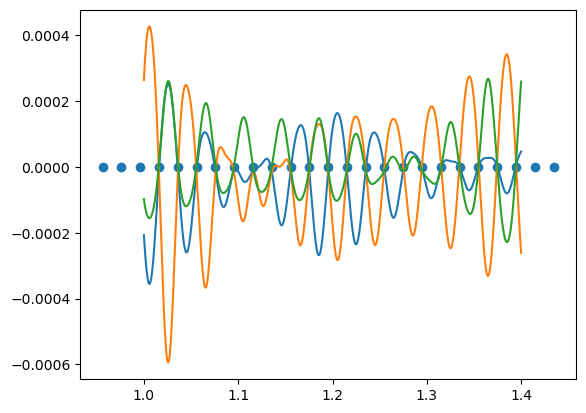

In [24]:
z = model.z
theta = model.theta
lower_t = 1.
end_t = 1.4
t_fine = jnp.linspace(lower_t,end_t,2000)
X_fine = model.predict_state(t_fine,z)
Xdot_fine = model.traj_model.derivative(t_fine,z)
colloc_res_fine = model.predict(X_fine,theta) - Xdot_fine
plt.plot(t_fine,colloc_res_fine[:,0])
plt.plot(t_fine,colloc_res_fine[:,1])
plt.plot(t_fine,colloc_res_fine[:,2])

colloc_plot = model.t_colloc[(model.t_colloc<=end_t+0.05)&(model.t_colloc>=lower_t - 0.05)]
plt.scatter(colloc_plot,0*colloc_plot)

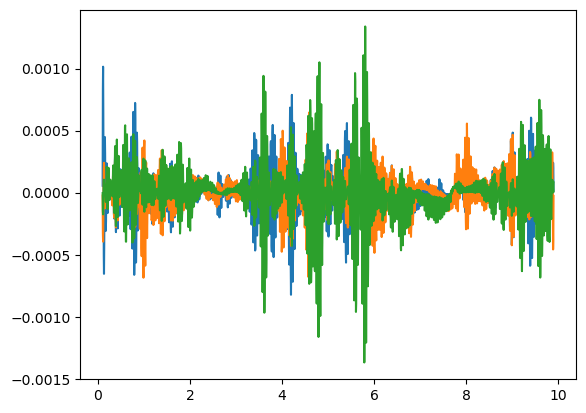

In [25]:
z = model.z
theta = model.theta
t_fine = jnp.linspace(0.1,9.9,2000)
X_fine = model.predict_state(t_fine,z)
Xdot_fine = model.traj_model.derivative(t_fine,z)
colloc_res_fine = model.predict(X_fine,theta) - Xdot_fine
plt.plot(t_fine,colloc_res_fine[:,0])
plt.plot(t_fine,colloc_res_fine[:,1])
plt.plot(t_fine,colloc_res_fine[:,2])

In [26]:
t_grid = jnp.linspace(0,10,500)

xdot_pred = model.traj_model.derivative(t_grid,model.z)
x_pred = model.predict_state(t_grid)
A = dynamics_model.feature_map(x_pred)

from pysindy import STLSQ,SR3,EnsembleOptimizer,SSR,MIOSR
stlsq = STLSQ(threshold = 0.25,alpha =0.1,unbias = True)
optimizer = stlsq

optimizer = MIOSR(7,alpha = 0.)
# EnsembleOptimizer(
#     stlsq,library_ensemble=True,
#     bagging = True,
#     n_models = 5000,
#     n_candidates_to_drop=2
#     )
# optimizer = SSR(criteria = 'model_residual',kappa = 0.1,alpha = 0.01)
optimizer.fit(A,xdot_pred)
refit_theta = jnp.array(optimizer.coef_).T

model.print(refit_theta)

(x)' = -9.761 x + 10.077 y
(y)' = 27.462 x + -1.097 y + -0.964 x z
(z)' = -2.687 z + 1.046 x y


In [31]:
import diffrax
def model_ode(t,x,args=None):
    return model.predict(x,model.theta)
# def model_ode(t,x,args=None):
#     return model.predict(x,refit_theta)


term = diffrax.ODETerm(model_ode)
solver = diffrax.Tsit5()
save_at = diffrax.SaveAt(ts = t_grid)
pidcontroller = diffrax.PIDController(rtol = 1e-8,atol = 1e-8)
sol = diffrax.diffeqsolve(
    term,
    solver,
    t0=t0,
    t1=t1,
    dt0=0.0005, 
    y0=initial_state,
    saveat=save_at,
    max_steps = int(500*(t1-t0)/dt),
    args = None,
    stepsize_controller=pidcontroller
)

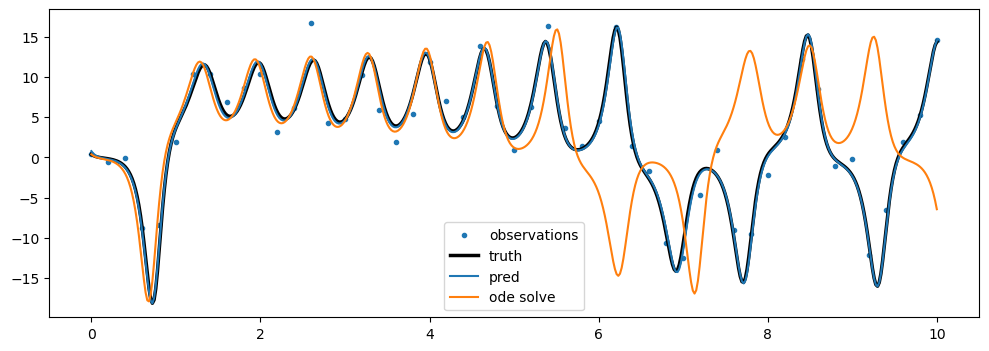

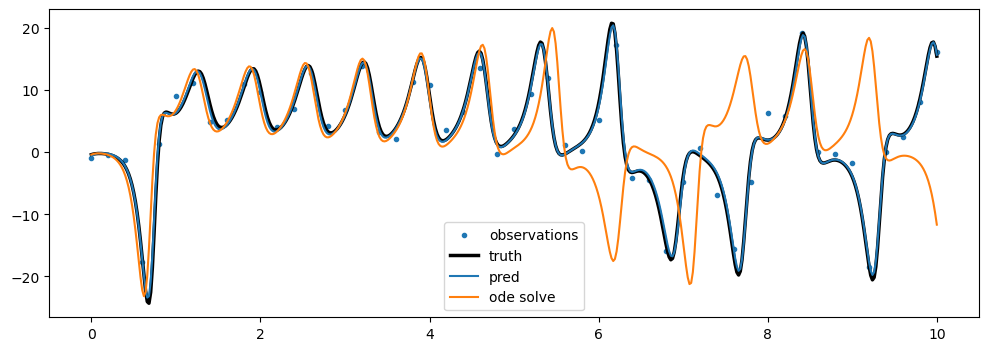

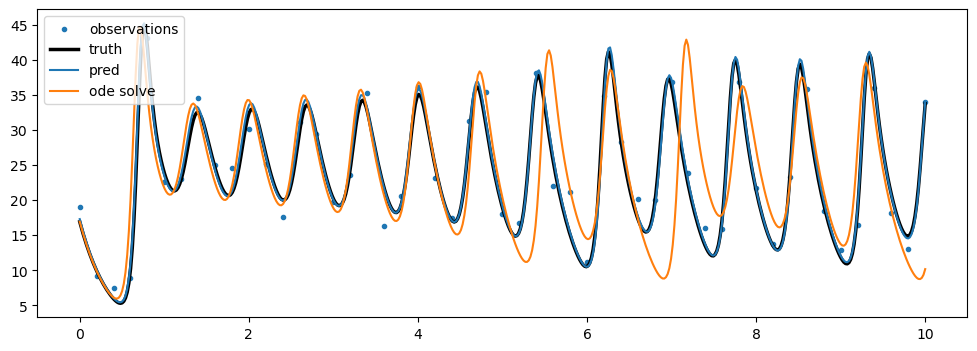

In [32]:
t_grid = jnp.linspace(0,10,500)
state_preds = model.predict_state(t_grid)
true_states = jax.vmap(expdata.system_sol.evaluate)(t_grid)
for dim in range(3):
    plt.figure(figsize=(12,4))
    plt.scatter(expdata.t_train,expdata.x_train[:,dim],label = 'observations',s = 9)
    plt.plot(t_grid,true_states[:,dim],label = 'truth',c='black',lw = 2.5)
    plt.plot(t_grid,state_preds[:,dim],label = 'pred')
    plt.plot(t_grid,sol.ys[:,dim],label = 'ode solve')
    plt.legend()
    plt.show()
